# Librairies

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

2024-11-23 19:31:38.710349: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-23 19:31:38.743335: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-23 19:31:38.769972: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-23 19:31:38.778766: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-23 19:31:38.798777: I tensorflow/core/platform/cpu_feature_guar

# Chargement de données

In [2]:
train_base_dir = '../Data/Data/'
clear_dir = os.path.join(train_base_dir, 'clear')
classes = ['clear', 'distorsion1', 'distorsion2', 'distorsion3','mvt1','mvt2','mvt3','gauss1','gauss2','gauss3','pixel1','pixel2','pixel3'] 

def verifier_et_lister_contenu(repertoire):
    if os.path.exists(repertoire):
        print(f"Le dossier '{repertoire}' contient les fichiers suivants :")
        for filename in os.listdir(repertoire):
            print(filename)
    else:
        print(f"Le dossier '{repertoire}' n'existe pas. Vérifiez le chemin.")

verifier_et_lister_contenu(clear_dir)


image_size = (128, 128)
batch_size = 64  


def charger_et_preparer_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)  
    img = tf.image.resize(img, image_size)  
    img = img / 255.0  
    return img


def charger_images_et_labels(repertoire, label):
    images_paths = [os.path.join(repertoire, filename) for filename in os.listdir(repertoire)]
    labels = [label] * len(images_paths)
    return images_paths, labels

clear_images, clear_labels = charger_images_et_labels(clear_dir, 0)

def create_tf_dataset(image_paths, labels, batch_size, shuffle_data=True):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda img_path, label: (charger_et_preparer_image(img_path), label), num_parallel_calls=tf.data.AUTOTUNE)
    
    if shuffle_data:
        dataset = dataset.shuffle(buffer_size=1000)
    
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


Le dossier '../Data/Data/clear' contient les fichiers suivants :
clear_34.jpg
clear_172.jpg
clear_1576.jpg
clear_1107.jpg
clear_2747.jpg
clear_3468.jpg
clear_3386.jpg
clear_38.jpg
clear_4179.jpg
clear_4279.jpg
clear_848.jpg
clear_1857.jpg
clear_3676.jpg
clear_1239.jpg
clear_2803.jpg
clear_992.jpg
clear_2422.jpg
clear_1462.jpg
clear_2972.jpg
clear_1630.jpg
clear_1297.jpg
clear_2647.jpg
clear_3237.jpg
clear_2322.jpg
clear_495.jpg
clear_259.jpg
clear_3166.jpg
clear_2242.jpg
clear_2088.jpg
clear_132.jpg
clear_3547.jpg
clear_62.jpg
clear_1096.jpg
clear_116.jpg
clear_1321.jpg
clear_2632.jpg
clear_2597.jpg
clear_3158.jpg
clear_3298.jpg
clear_2015.jpg
clear_3218.jpg
clear_2283.jpg
clear_2195.jpg
clear_3331.jpg
clear_286.jpg
clear_143.jpg
clear_3418.jpg
clear_1608.jpg
clear_3945.jpg
clear_3980.jpg
clear_3633.jpg
clear_1413.jpg
clear_3718.jpg
clear_847.jpg
clear_905.jpg
clear_3473.jpg
clear_2908.jpg
clear_2207.jpg
clear_190.jpg
clear_1751.jpg
clear_3085.jpg
clear_741.jpg
clear_511.jpg
clear_3839

# Création du modèle

In [3]:


def create_model():
    model = keras.models.Sequential([
        keras.layers.Input((128, 128, 3)),
        keras.layers.Conv2D(32, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(2, activation='softmax')  # 2 classes
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [4]:
def process_model(model,obscur_dir) :

    obscur_images, obscur_labels = charger_images_et_labels(obscur_dir, 1)
    all_images = clear_images + obscur_images
    all_labels = clear_labels + obscur_labels
    X_train, X_val, y_train, y_val = train_test_split(all_images, all_labels, test_size=0.2, stratify=all_labels)



    train_dataset = create_tf_dataset(X_train, y_train,batch_size,True)
    validation_dataset = create_tf_dataset(X_val, y_val,batch_size,False)
    train_labels = np.concatenate([labels for _, labels in train_dataset], axis=0)
    val_labels = np.concatenate([labels for _, labels in validation_dataset], axis=0)
    print(f"Distribution des labels dans le jeu d'entraînement: {np.bincount(train_labels)}")
    print(f"Distribution des labels dans le jeu de validation: {np.bincount(val_labels)}")


    history = model.fit(
        train_dataset, 
        validation_data=validation_dataset,  
        epochs=10,   
        verbose=1    
    ) 

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title("Model accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    predictions = model.predict(validation_dataset)
    predictions = np.argmax(predictions, axis=1)
    true_labels = val_labels
    print(classification_report(true_labels, predictions))
    print(f"True labels: {true_labels[:10]}")
    print(f"Predictions: {predictions[:10]}")
    print(f"Shape of true_labels: {true_labels.shape}")
    print(f"Shape of predictions: {predictions.shape}")

    cm = confusion_matrix(true_labels, predictions, labels=[0, 1])
    class_names = [str(0),str(1)]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.savefig("matrice.png")
    plt.show()

    

# Distorsion

In [ ]:
# DIstorsion1

model=create_model()
distorsion1_dir = os.path.join(train_base_dir, 'distorsion1')
process_model(model,distorsion1_dir)

# Sauvegarde du modèle
model.save('model_dist1.keras') #modele lourd pour push sur git





67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step


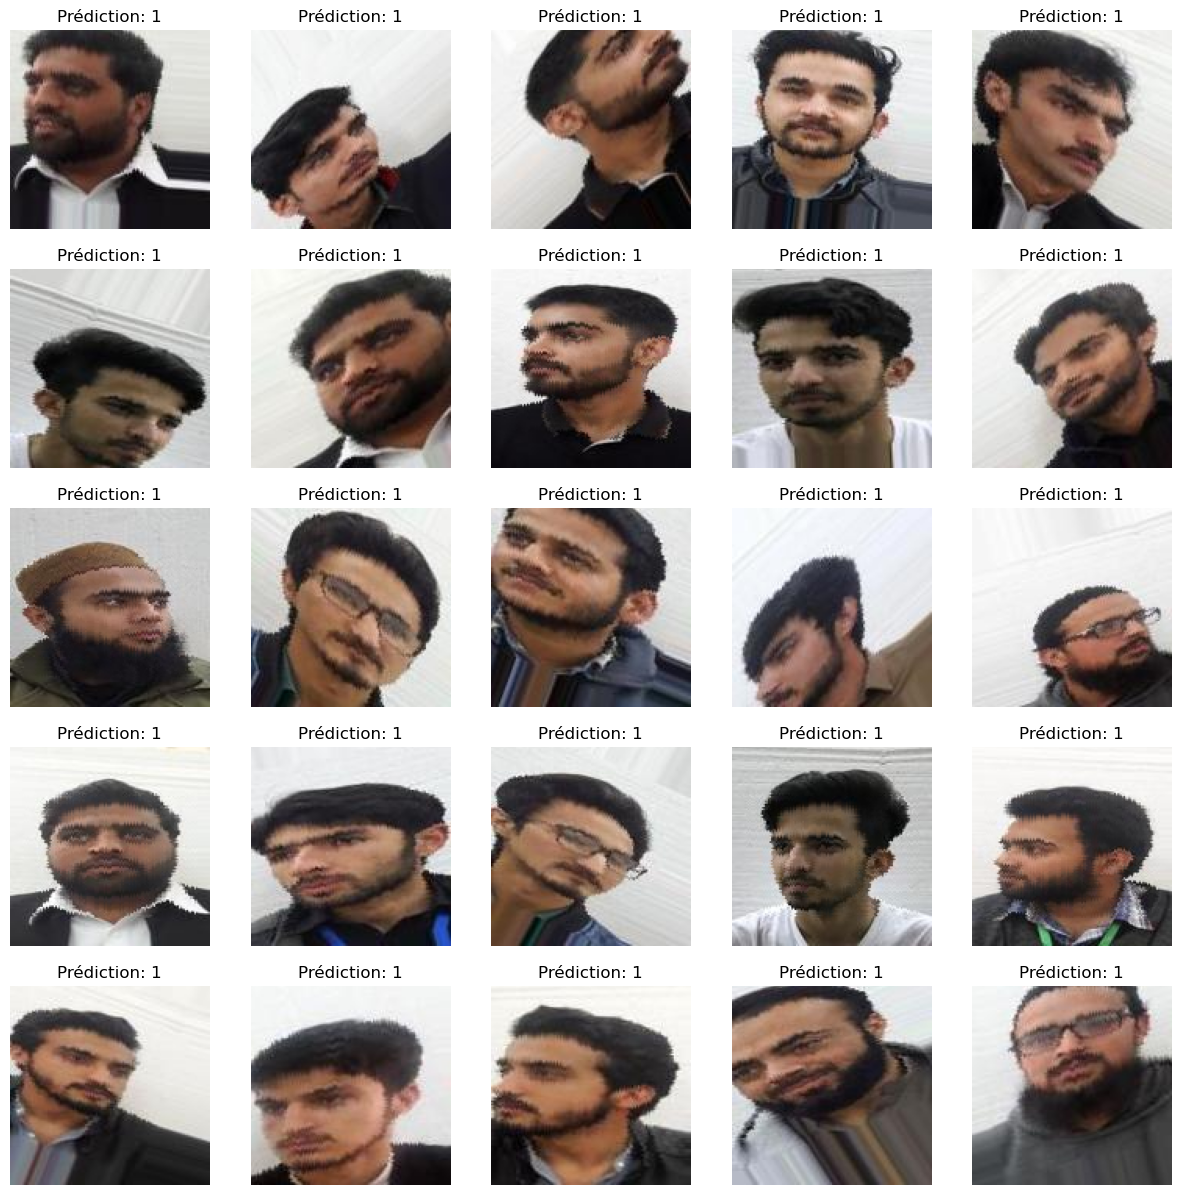

Matrice de confusion:
[[   0    0]
 [ 438 3827]]

Rapport de classification:
              precision    recall  f1-score   support

    Classe 0       0.00      0.00      0.00         0
    Classe 1       1.00      0.90      0.95      4265

    accuracy                           0.90      4265
   macro avg       0.50      0.45      0.47      4265
weighted avg       1.00      0.90      0.95      4265


Précision globale: 89.73%


/home/thomas/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/thomas/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/thomas/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# fgsm dist1


fgsmmvt1_dir = os.path.join(train_base_dir, 'fgsmdist1_')
model_path = '../modeles/model_dist1.keras'

model = tf.keras.models.load_model(model_path)

images_paths, labels = charger_images_et_labels(fgsmmvt1_dir, label=1)  

dataset = create_tf_dataset(images_paths, labels, batch_size, shuffle_data=False)

predictions = model.predict(dataset)
predicted_classes = np.argmax(predictions, axis=1)

def display_predictions(images_paths, predictions):
    plt.figure(figsize=(15, 15))
    for i in range(min(len(images_paths), 25)):
        plt.subplot(5, 5, i + 1)
        img = plt.imread(images_paths[i])
        plt.imshow(img)
        plt.title(f"Prédiction: {np.argmax(predictions[i])}")
        plt.axis('off')
    plt.show()

display_predictions(images_paths, predictions)

true_labels = np.array(labels)
conf_matrix = confusion_matrix(true_labels, predicted_classes)

class_report = classification_report(true_labels, predicted_classes, target_names=['Classe 0', 'Classe 1'], labels=[0, 1])
accuracy = np.mean(true_labels == predicted_classes)

print("Matrice de confusion:")
print(conf_matrix)
print("\nRapport de classification:")
print(class_report)
print(f"\nPrécision globale: {accuracy * 100:.2f}%")


In [ ]:
# DIstorsion2

model=create_model()
distorsion2_dir = os.path.join(train_base_dir, 'distorsion2')
process_model(model,distorsion2_dir)
# Sauvegarde du modèle
model.save('model_dist2.keras') #modele lourd pour push sur git





In [ ]:
# DIstorsion3

model=create_model()
distorsion3_dir = os.path.join(train_base_dir, 'distorsion3')
process_model(model,distorsion3_dir)

# Sauvegarde du modèle
model.save('model_dist3.keras') #modele lourd pour push sur git




# Flou Mouvement

In [ ]:
# Mvt1

model=create_model()
mvt1_dir = os.path.join(train_base_dir, 'mvt1')
process_model(model,mvt1_dir)

# Sauvegarde du modèle
model.save('model_mvt1.keras') #modele lourd pour push sur git


68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step


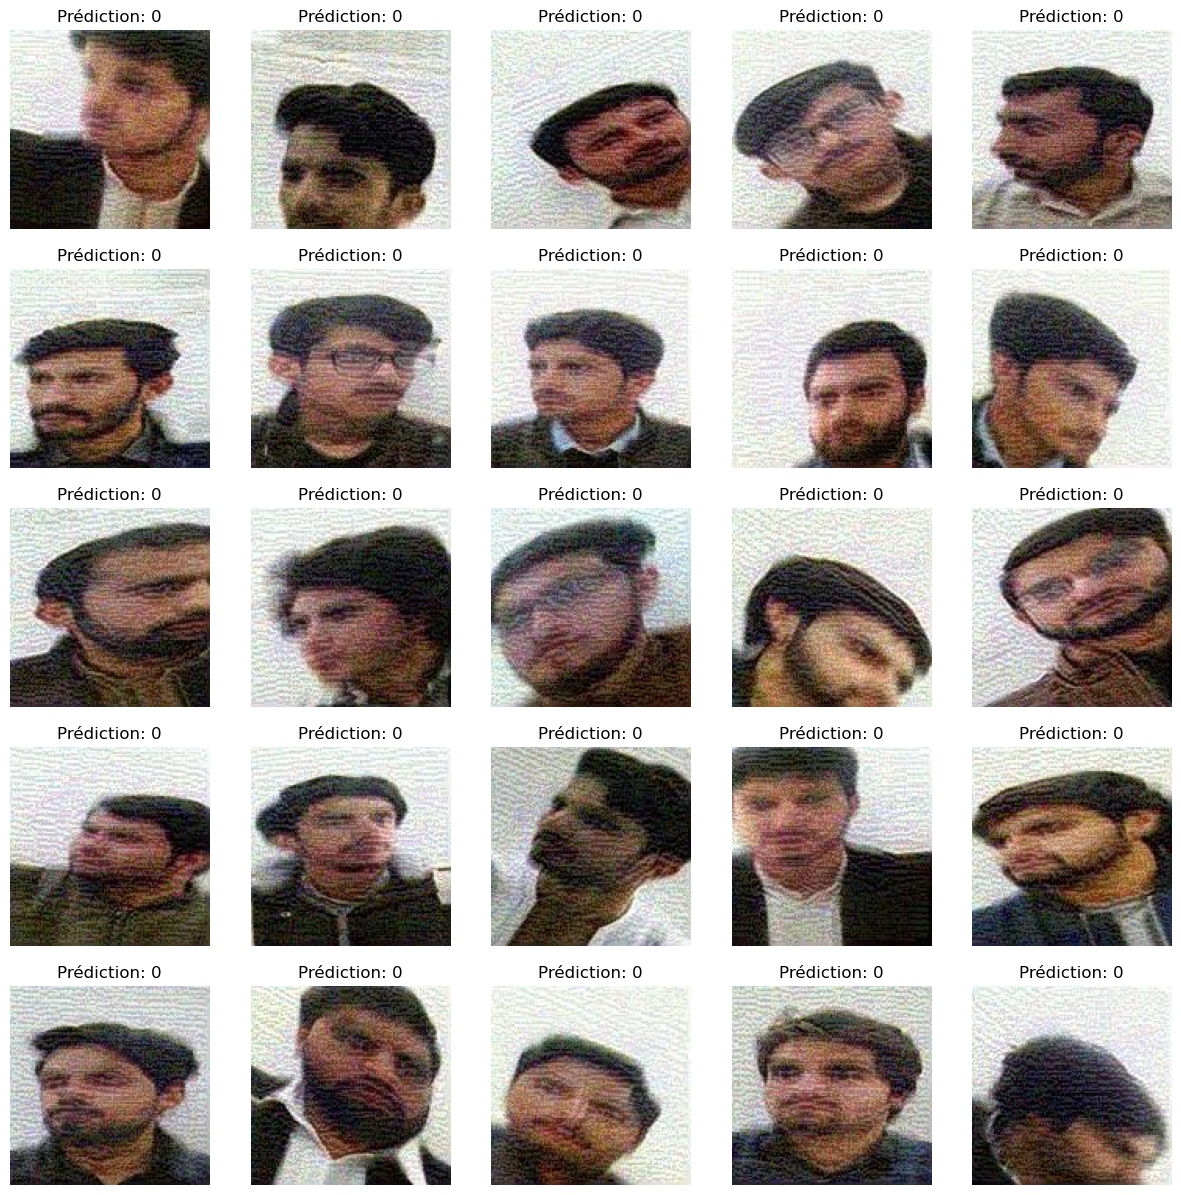

Matrice de confusion:
[[   0    0]
 [4290    0]]

Rapport de classification:
              precision    recall  f1-score   support

    Classe 0       0.00      0.00      0.00       0.0
    Classe 1       0.00      0.00      0.00    4290.0

    accuracy                           0.00    4290.0
   macro avg       0.00      0.00      0.00    4290.0
weighted avg       0.00      0.00      0.00    4290.0


Précision globale: 0.00%


/home/thomas/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/thomas/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/thomas/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/thomas/.local/lib/python

In [8]:
# fgsm mvt1


fgsmmvt1_dir = os.path.join(train_base_dir, 'fgsmmvt1')
model_path = '../modeles/model_mvt1.keras'

model = tf.keras.models.load_model(model_path)

images_paths, labels = charger_images_et_labels(fgsmmvt1_dir, label=1)  

dataset = create_tf_dataset(images_paths, labels, batch_size, shuffle_data=False)

predictions = model.predict(dataset)
predicted_classes = np.argmax(predictions, axis=1)

def display_predictions(images_paths, predictions):
    plt.figure(figsize=(15, 15))
    for i in range(min(len(images_paths), 25)):
        plt.subplot(5, 5, i + 1)
        img = plt.imread(images_paths[i])
        plt.imshow(img)
        plt.title(f"Prédiction: {np.argmax(predictions[i])}")
        plt.axis('off')
    plt.show()

display_predictions(images_paths, predictions)

true_labels = np.array(labels)
conf_matrix = confusion_matrix(true_labels, predicted_classes)

class_report = classification_report(true_labels, predicted_classes, target_names=['Classe 0', 'Classe 1'], labels=[0, 1])
accuracy = np.mean(true_labels == predicted_classes)

print("Matrice de confusion:")
print(conf_matrix)
print("\nRapport de classification:")
print(class_report)
print(f"\nPrécision globale: {accuracy * 100:.2f}%")


In [ ]:
# Mvt2

model=create_model()
mvt2_dir = os.path.join(train_base_dir, 'mvt2')
process_model(model,mvt2_dir)
# Sauvegarde du modèle
model.save('model_mvt2.keras') #modele lourd pour push sur git


In [ ]:
# Mvt3

model=create_model()
mvt3_dir = os.path.join(train_base_dir, 'mvt3')
process_model(model,mvt3_dir)
# Sauvegarde du modèle
model.save('model_mvt3.keras') #modele lourd pour push sur git



# Flou gaussien

In [ ]:
# Gauss1

model=create_model()
gauss1_dir = os.path.join(train_base_dir, 'gauss1')
process_model(model,gauss1_dir)
# Sauvegarde du modèle
model.save('model_gauss1.keras') #modele lourd pour push sur git



In [ ]:
# Gauss2

model=create_model()
gauss2_dir = os.path.join(train_base_dir, 'gauss2')
process_model(model,gauss2_dir)
# Sauvegarde du modèle
model.save('model_gauss2.keras') #modele lourd pour push sur git


In [ ]:
# Gauss3

model=create_model()
gauss3_dir = os.path.join(train_base_dir, 'gauss3')
process_model(model,gauss3_dir)
# Sauvegarde du modèle
model.save('model_gauss3.keras') #modele lourd pour push sur git


# Pixelisation

In [ ]:
# Pixel1

model=create_model()
pixel1_dir = os.path.join(train_base_dir, 'pixel1')
process_model(model,pixel1_dir)
# Sauvegarde du modèle
model.save('model_pixel1.keras') #modele lourd pour push sur git


In [ ]:
# Pixel2

model=create_model()
pixel2_dir = os.path.join(train_base_dir, 'pixel1')
process_model(model,pixel2_dir)
# Sauvegarde du modèle
model.save('model_pixel2.keras') #modele lourd pour push sur git

In [ ]:
# Pixel3

model=create_model()
pixel3_dir = os.path.join(train_base_dir, 'pixel3')
process_model(model,pixel3_dir)
# Sauvegarde du modèle
model.save('model_pixel3.keras') #modele lourd pour push sur git

# Pixel Permutation

In [ ]:
# PixelPermut1

model=create_model()
pixelpermut1_dir = os.path.join(train_base_dir, 'pixelpermut1')
process_model(model,pixelpermut1_dir)
# Sauvegarde du modèle
model.save('model_pixelpermut1.keras') #modele lourd pour push sur git

In [ ]:
# PixelPermut2

model=create_model()
pixelpermut2_dir = os.path.join(train_base_dir, 'pixelpermut2')
process_model(model,pixelpermut2_dir)
# Sauvegarde du modèle
model.save('model_pixelpermut2.keras') #modele lourd pour push sur git

In [ ]:
# PixelPermut3

model=create_model()
pixelpermut3_dir = os.path.join(train_base_dir, 'pixelpermut3')
process_model(model,pixelpermut3_dir)
# Sauvegarde du modèle
model.save('model_pixelpermut3.keras') #modele lourd pour push sur git

# FGSM

In [ ]:
# FGSM1

model=create_model()
fgsm1_dir = os.path.join(train_base_dir, 'fgsm1')
process_model(model,fgsm1_dir)
# Sauvegarde du modèle
model.save('model_fgsm1.keras') #modele lourd pour push sur git

In [ ]:
# FGSM2

model=create_model()
fgsm2_dir = os.path.join(train_base_dir, 'fgsm2')
process_model(model,fgsm2_dir)
# Sauvegarde du modèle
model.save('model_fgsm2.keras') #modele lourd pour push sur git

In [ ]:
# FGSM3

model=create_model()
fgsm3_dir = os.path.join(train_base_dir, 'fgsm3')
process_model(model,fgsm3_dir)
# Sauvegarde du modèle
model.save('model_fgsm3.keras') #modele lourd pour push sur git

# Modele toute methode

Distribution des labels dans le jeu d'entraînement: [3451 3452 3462 3434 3442 5239]
Distribution des labels dans le jeu de validation: [ 863  863  865  858  861 1310]
Epoch 1/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 85s 237ms/step - accuracy: 0.6166 - loss: 1.0043 - val_accuracy: 0.9157 - val_loss: 0.2410
Epoch 2/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 85s 241ms/step - accuracy: 0.9252 - loss: 0.2029 - val_accuracy: 0.9354 - val_loss: 0.1588
Epoch 3/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 85s 242ms/step - accuracy: 0.9634 - loss: 0.1010 - val_accuracy: 0.9423 - val_loss: 0.1496
Epoch 4/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 90s 256ms/step - accuracy: 0.9826 - loss: 0.0541 - val_accuracy: 0.9699 - val_loss: 0.0823
Epoch 5/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 87s 246ms/step - accuracy: 0.9895 - loss: 0.0324 - val_accuracy: 0.9753 - val_loss: 0.0651
Epoch 6/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 83s 235ms/step - accuracy: 0.9958 - loss: 0.0164 - val_accuracy: 0.9742 - val_loss: 0.0704
Epoch 7/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 83s 235

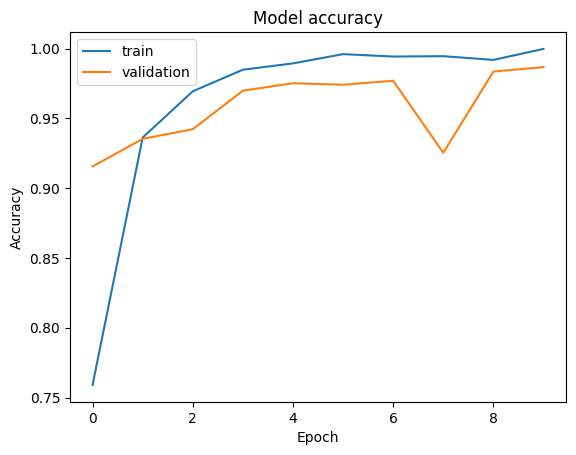

88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       863
           1       1.00      1.00      1.00       863
           2       0.98      0.96      0.97       865
           3       0.96      0.98      0.97       858
           4       0.99      0.98      0.99       861
           5       1.00      1.00      1.00      1310

    accuracy                           0.99      5620
   macro avg       0.99      0.99      0.99      5620
weighted avg       0.99      0.99      0.99      5620

True labels: [5 0 1 5 5 4 1 5 2 3]
Predictions: [5 0 1 5 5 4 1 5 2 3]
Shape of true_labels: (5620,)
Shape of predictions: (5620,)


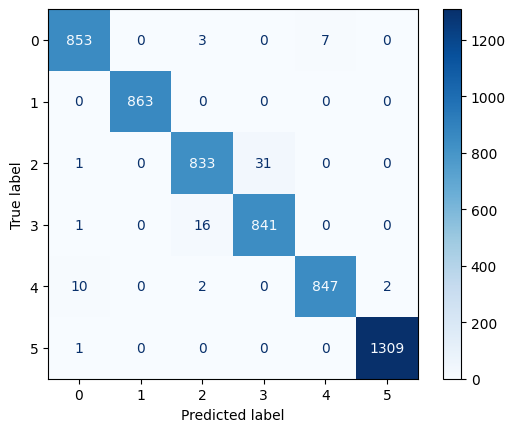

In [ ]:
model = keras.models.Sequential([
        keras.layers.Input((128, 128, 3)),
        keras.layers.Conv2D(32, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(5, activation='softmax')  # 6 classes
    ])
model.compile(optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

distorsion2_dir = os.path.join(train_base_dir, 'distorsion2')
mvt2_dir = os.path.join(train_base_dir, 'mvt2')
gauss2_dir = os.path.join(train_base_dir, 'gauss2')
pixel2_dir = os.path.join(train_base_dir, 'pixel2')
dist_images, dist_labels = charger_images_et_labels(distorsion2_dir, 1)
mvt_images, mvt_labels = charger_images_et_labels(mvt2_dir, 2)
gauss_images, gauss_labels = charger_images_et_labels(gauss2_dir, 3)
pixel_images, pixel_labels = charger_images_et_labels(pixel2_dir, 4)
all_images = clear_images + dist_images+mvt_images+gauss_images+pixel_images
all_labels = clear_labels + dist_labels+mvt_labels+gauss_labels+pixel_labels
X_train, X_val, y_train, y_val = train_test_split(all_images, all_labels, test_size=0.2, stratify=all_labels)
train_dataset = create_tf_dataset(X_train, y_train,batch_size,True)
validation_dataset = create_tf_dataset(X_val, y_val,batch_size,False)
train_labels = np.concatenate([labels for _, labels in train_dataset], axis=0)
val_labels = np.concatenate([labels for _, labels in validation_dataset], axis=0)
print(f"Distribution des labels dans le jeu d'entraînement: {np.bincount(train_labels)}")
print(f"Distribution des labels dans le jeu de validation: {np.bincount(val_labels)}")

history = model.fit(
        train_dataset, 
        validation_data=validation_dataset,  
        epochs=10,   
        verbose=1    
) 

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

predictions = model.predict(validation_dataset)
predictions = np.argmax(predictions, axis=1)
true_labels = val_labels
print(classification_report(true_labels, predictions))
print(f"True labels: {true_labels[:10]}")
print(f"Predictions: {predictions[:10]}")
print(f"Shape of true_labels: {true_labels.shape}")
print(f"Shape of predictions: {predictions.shape}")

cm = confusion_matrix(true_labels, predictions, labels=[0, 1,2,3,4])
class_names = [str(0),str(1),str(2),str(3),str(4)]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.savefig("matrice.png")
plt.show()

In [24]:
model.save('model_toutemethode.keras') #modele lourd pour push sur git

Distribution des labels dans le jeu d'entraînement: [3451 3412 3432 3450 3413 5258]
Distribution des labels dans le jeu de validation: [ 863  853  858  862  853 1315]
Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 82s 231ms/step - accuracy: 0.2441 - loss: 1.8518 - val_accuracy: 0.3747 - val_loss: 1.3540
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 99s 282ms/step - accuracy: 0.4477 - loss: 1.2527 - val_accuracy: 0.5068 - val_loss: 1.0943
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 89s 252ms/step - accuracy: 0.5610 - loss: 1.0133 - val_accuracy: 0.5905 - val_loss: 0.9989
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 86s 244ms/step - accuracy: 0.6277 - loss: 0.8799 - val_accuracy: 0.6925 - val_loss: 0.7263
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 89s 252ms/step - accuracy: 0.7106 - loss: 0.6954 - val_accuracy: 0.6934 - val_loss: 0.7219
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 92s 261ms/step - accuracy: 0.7401 - loss: 0.6174 - val_accuracy: 0.6859 - val_loss: 0.7322
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 98s 280

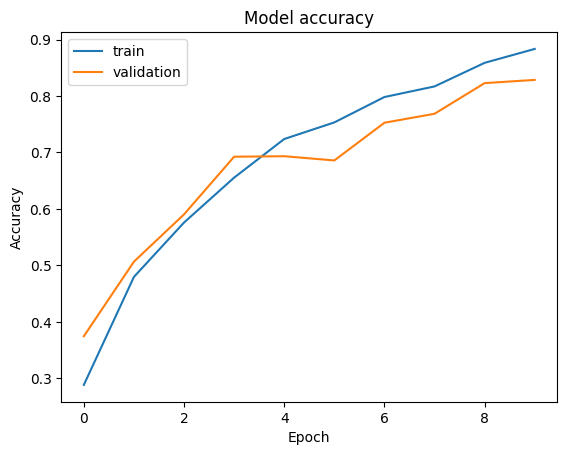

88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step
              precision    recall  f1-score   support

           0       0.78      0.83      0.80       863
           1       0.65      0.60      0.62       853
           2       0.93      0.99      0.96       858
           3       0.90      0.92      0.91       862
           4       0.70      0.76      0.73       853
           5       0.94      0.86      0.90      1315

    accuracy                           0.83      5604
   macro avg       0.82      0.83      0.82      5604
weighted avg       0.83      0.83      0.83      5604

True labels: [4 5 3 0 2 2 5 5 5 0]
Predictions: [4 0 3 0 2 2 5 5 5 0]
Shape of true_labels: (5604,)
Shape of predictions: (5604,)


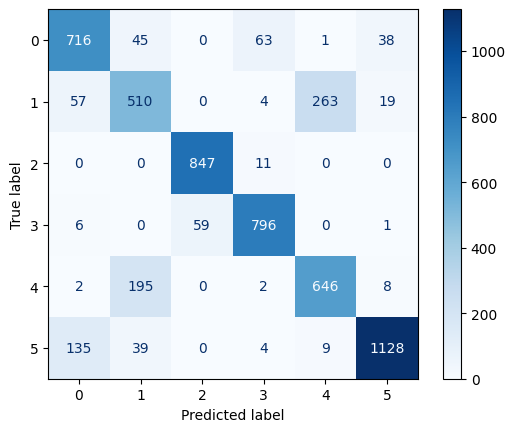

In [ ]:
model = keras.models.Sequential([
        keras.layers.Input((128, 128, 3)),
        keras.layers.Conv2D(32, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(5, activation='softmax')  # 6 classes
    ])
model.compile(optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

distorsion1_dir = os.path.join(train_base_dir, 'distorsion1')
mvt1_dir = os.path.join(train_base_dir, 'mvt1')
gauss1_dir = os.path.join(train_base_dir, 'gauss1')
pixel1_dir = os.path.join(train_base_dir, 'pixel1')
dist_images, dist_labels = charger_images_et_labels(distorsion1_dir, 1)
mvt_images, mvt_labels = charger_images_et_labels(mvt1_dir, 2)
gauss_images, gauss_labels = charger_images_et_labels(gauss1_dir, 3)
pixel_images, pixel_labels = charger_images_et_labels(pixel1_dir, 4)
all_images = clear_images + dist_images+mvt_images+gauss_images+pixel_images
all_labels = clear_labels + dist_labels+mvt_labels+gauss_labels+pixel_labels
X_train, X_val, y_train, y_val = train_test_split(all_images, all_labels, test_size=0.2, stratify=all_labels)
train_dataset = create_tf_dataset(X_train, y_train,batch_size,True)
validation_dataset = create_tf_dataset(X_val, y_val,batch_size,False)
train_labels = np.concatenate([labels for _, labels in train_dataset], axis=0)
val_labels = np.concatenate([labels for _, labels in validation_dataset], axis=0)
print(f"Distribution des labels dans le jeu d'entraînement: {np.bincount(train_labels)}")
print(f"Distribution des labels dans le jeu de validation: {np.bincount(val_labels)}")

history = model.fit(
        train_dataset, 
        validation_data=validation_dataset,  
        epochs=10,   
        verbose=1    
) 

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

predictions = model.predict(validation_dataset)
predictions = np.argmax(predictions, axis=1)
true_labels = val_labels
print(classification_report(true_labels, predictions))
print(f"True labels: {true_labels[:10]}")
print(f"Predictions: {predictions[:10]}")
print(f"Shape of true_labels: {true_labels.shape}")
print(f"Shape of predictions: {predictions.shape}")

cm = confusion_matrix(true_labels, predictions, labels=[0, 1,2,3,4])
class_names = [str(0),str(1),str(2),str(3),str(4)]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.savefig("matrice.png")
plt.show()

model.save('model_toutemethode.keras') #modele lourd pour push sur git